<a href="https://colab.research.google.com/github/fab2112/Q-network_taxi-v3-Tensorflow2-demo/blob/main/Q_network_taxi_v3_Tensorflow2_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstração do algorítmo Q-network no ambiente *taxi-v3* *openai* *gym* 
Este notebbok utiliza a biblioteca Tensorflow 2 para otimização de valores da tabela Q_table (Baseado em Q-learning)

https://gym.openai.com/envs/Taxi-v3/

# Importa bibliotecas

In [9]:
from time import sleep, time
import numpy as np
import gym.spaces
import tensorflow as tf
import os
import logging
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

# Instancia ambiente, inicializa variaveis e define parâmetros

In [10]:
# Instancia ambiente Taxi-v3 no gym
env = gym.make("Taxi-v3")

# Inicializa variáveis
Q_table = tf.Variable(tf.zeros([env.observation_space.n, env.action_space.n]), dtype=tf.float32)
Q_next_state = tf.Variable(tf.zeros([1, env.action_space.n], dtype=tf.float32))
action = tf.Variable(tf.zeros([1, ], dtype=tf.int64))
total_epochs = 0
total_rewards = []

# Parâmetros Q-learning
gamma = 0.7  # Future rewards
epsilon = 0.6  # Exploration / exploitation
epsilon_decay = .99
episodes = 4000  # Rollouts
learning_rate = 0.3

# Fase de treino

In [11]:
for episode in range(episodes):

    time_before = float(time() * 1000)

    reward = 0
    epochs = 0
    rewards_by_episode = 0
    state = env.reset()

    done = False
    while not done:

        # Seleciona uma ação aleatória - Exploration
        if np.random.rand(1) < epsilon:
            action.assign([env.action_space.sample()])
        # Seleciona uma ação com maior valor Q - Exploitation
        else:
            action.assign(tf.argmax(Q_table[state:state + 1], 1))

        # Move para próximo estado e atualiza parâmetros
        next_state, reward, done, info = env.step(action[0].numpy())

        # Atribui valores para tensor Q_next_state 
        Q_next_state.assign(Q_table[state:state + 1])

        # Atualiza o valor da ultima ação para Q_next_state - Equação de Bellman
        Q_next_state[0, action[0]].assign(reward + gamma * np.max(Q_table[next_state:next_state + 1]))

        # Computa gradiente (minimiza diferença entre os ultimos estados)
        with tf.GradientTape() as tape:
            # Função de perda => (state - next_state)**2
            j = tf.square(Q_table[state:state + 1] - Q_next_state)
        # Calcula derivadas parciais
        dp = tape.gradient(j, Q_table)

        # Atualização dos valores Q-Table
        Q_table.assign_sub(dp * learning_rate)

        # Atualiza state para o estado atual
        state = next_state

        # Computa rewards por episodio
        rewards_by_episode += reward

        # Computa epocas por episodio
        epochs += 1

    # Monitoramento da latência do treino por espiósdio
    time_after = float(time() * 1000)
    latency = "%.2f" % (time_after - time_before)
    #print("Episode " + str(episode) + " Latencia: " + str(latency) + " ms")

    # Decaimento de epsilon - Exploitation
    epsilon = epsilon * epsilon_decay
    total_epochs += epochs
    total_rewards.append(rewards_by_episode)
    clear_output(wait=True)
    print("Rewards by episodes: {}".format(rewards_by_episode))


print("\nSuccess rate epochs by episodes: {}".format(total_epochs / episodes))

Rewards by episodes: 4

Success rate epochs by episodes: 18.76175


# Plota rewards x episodes

<Figure size 432x288 with 0 Axes>

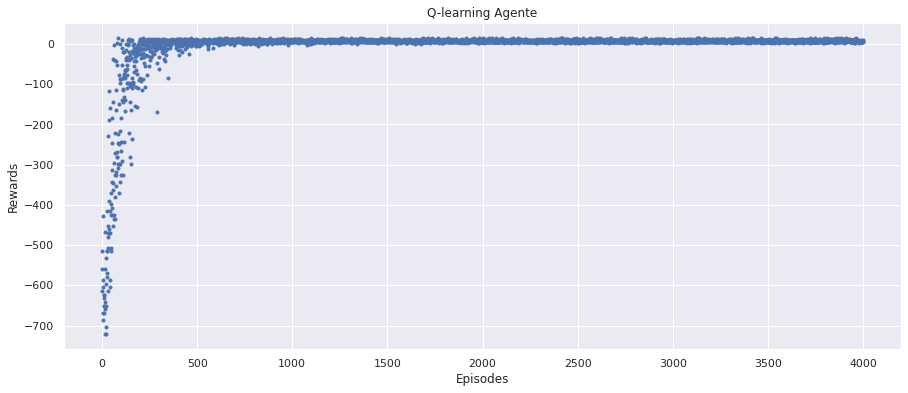

In [12]:
# Plot total_rewards
sns.set_theme()
plt.clf()
plt.figure(figsize=(15, 6))
plt.plot(total_rewards, marker='.', linestyle='none')
plt.title('Q-learning Agente')
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.show()

# Fase de teste

In [13]:
# Após treino
# Cria novo ambiente e vai para um estado aleatório
state = env.reset()
# Seleciona a ação indexada na Q_table com maior valor
action = np.argmax(Q_table[state])
for i in range(200):
    sleep(0.2)
    # Define o novo estado em função da ultima ação escolhida
    next_state, reward, done, info = env.step(action)
    # Seleciona a ação indexada com maior valor do vetor next_state
    action = np.argmax(Q_table[next_state])
    clear_output(wait=True)
    env.render()
    if reward >= 20:
        print("\n\nNOVO AMBIENTE\n\n")
        sleep(0.5)
        reward = 0
        # Cria novo ambiente e vai para um estado aleatório
        state = env.reset()
        # Seleciona a ação indexada com maior valor do vetor state
        action = np.argmax(Q_table[state])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
